In [44]:
include("../Inversion/Plot.jl")
include("Lorenz63.jl")


adjoint_plot (generic function with 1 method)

# Lorenz63 system
Consider the famous Lorenz63 system  elliptic equation

\begin{equation*}
\begin{split}
    &\frac{dx_1}{dt} = \sigma (x_2 - x_1), \\
    &\frac{dx_2}{dt} = x_1(r-x_3)-x_2,        \\
    &\frac{dx_3}{dt} = x_1x_2-\beta x_3;   \\
\end{split}
\end{equation*}

The system is parameterized by $\sigma, r, \beta \in \mathcal{R}^{+}$. For the usual values
$\sigma = 10, \beta=\frac{8}{3}$, we have 
* When $r < 24.74$, the system is not chaotic, the trajectory converges to one attractor 
* When $24.74 < r < 148.4$, the chaotic motion (strange attractor) appears
* When $148.4 < r < 166.07$, the limit cycle begins
* When $166.07 < r$, the system transits to strange attractor from limit cyle (intermmittency)[1].


1. Manneville, Paul, and Pomeau, Yves. "Intermittency and the Lorenz model." 



## Butterfly at r = 28

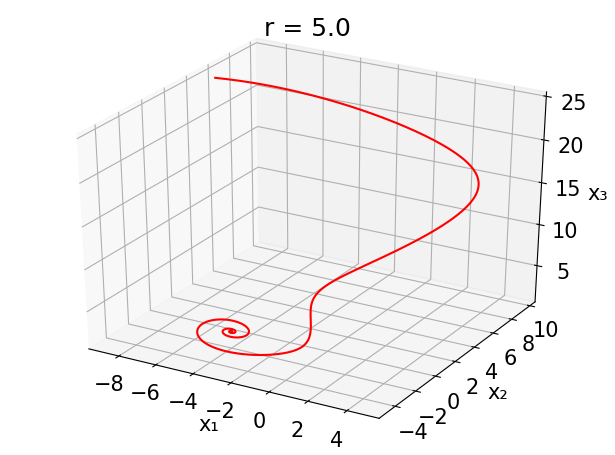

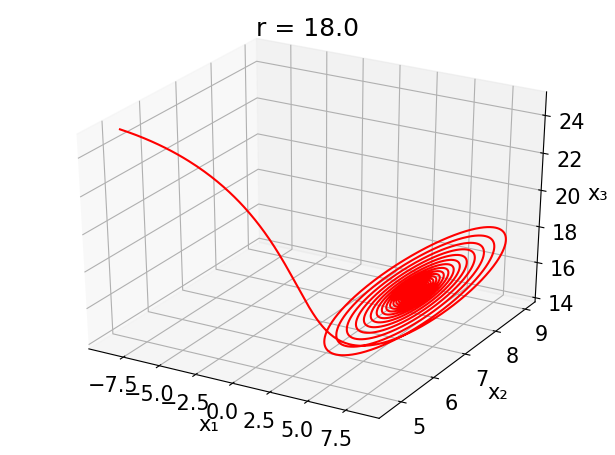

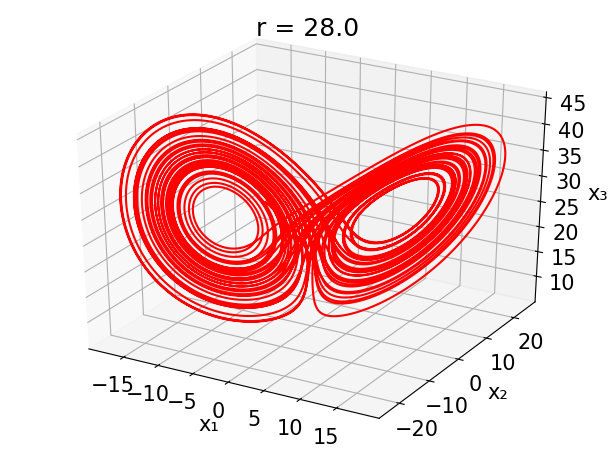

In [45]:
x0 = [-8.67139571762; 4.98065219709; 25]

T = 50
Δt = 0.001
N_t = Int64(T/Δt)


θ = [10.0; 5.0; 8.0/3.0]
xs = compute_Lorenz63_FE(x0, θ, Δt, N_t)
PyPlot.figure()
PyPlot.plot3D(xs[1,:], xs[2,:], xs[3,:], "red")
PyPlot.xlabel("x₁")
PyPlot.ylabel("x₂")
PyPlot.zlabel("x₃")
PyPlot.title("r = $(θ[2])")
PyPlot.tight_layout()


θ = [10.0; 18.0; 8.0/3.0]
xs = compute_Lorenz63_FE(x0, θ, Δt, N_t)
PyPlot.figure()
PyPlot.plot3D(xs[1,:], xs[2,:], xs[3,:], "red")
PyPlot.xlabel("x₁")
PyPlot.ylabel("x₂")
PyPlot.zlabel("x₃")
PyPlot.title("r = $(θ[2])")
PyPlot.tight_layout()


θ = [10.0; 28.0; 8.0/3.0]
xs = compute_Lorenz63_FE(x0, θ, Δt, N_t)
PyPlot.figure()
PyPlot.plot3D(xs[1,:], xs[2,:], xs[3,:], "red")
PyPlot.xlabel("x₁")
PyPlot.ylabel("x₂")
PyPlot.zlabel("x₃")
PyPlot.title("r = $(θ[2])")
PyPlot.tight_layout()

## Deterministic chaos

Small differences in initial conditions, such as those due to errors in measurements or due to rounding errors in 
numerical computation, can yield widely diverging outcomes for such dynamical systems.
    
For $r = 28$, we perturb the initial condition by $10^{-6}$.

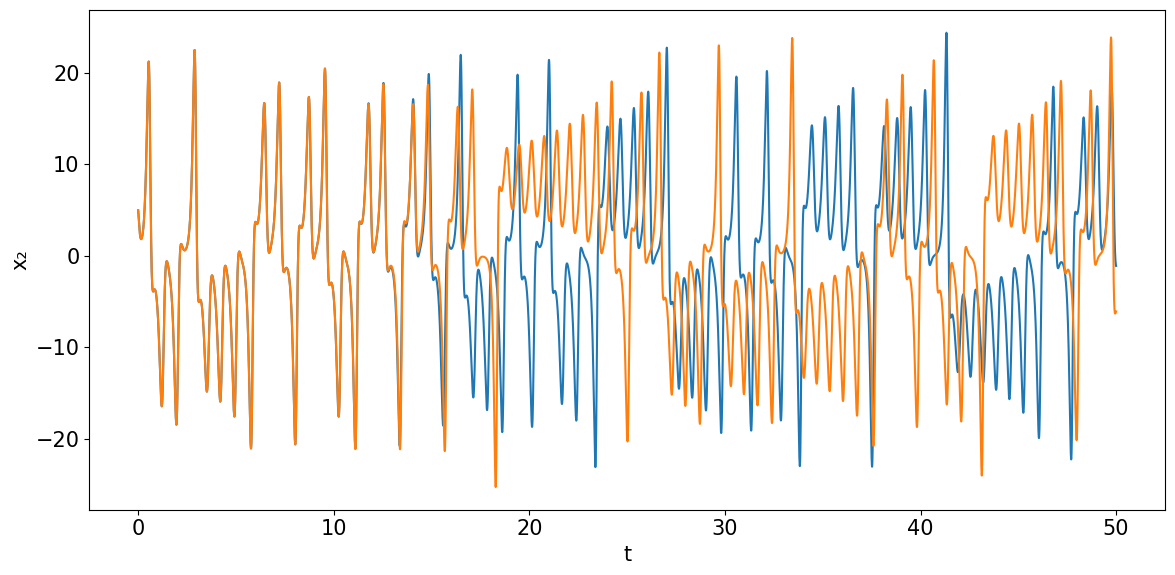

In [46]:
θ = [10.0; 28.0; 8.0/3.0]
T = 50
Δt = 0.001
N_t = Int64(T/Δt)
ts = Array(LinRange(0, T, N_t+1))


x0 = [-8.67139571762; 4.98065219709; 25]
xs = compute_Lorenz63_FE(x0, θ, Δt, N_t)
PyPlot.figure(figsize=(12,6))
PyPlot.plot(ts, xs[2,:])


x0 = [-8.67139571762; 4.98065219709; 25] + [0; 1e-6; 0]
xs = compute_Lorenz63_FE(x0, θ, Δt, N_t)
PyPlot.plot(ts, xs[2,:])

PyPlot.xlabel("t")
PyPlot.ylabel("x₂")
PyPlot.tight_layout()

## Discrete adjoint method

We consider the following one-parameter inverse problem with fixed $\sigma=10$ and $\beta=8/3$:
\begin{equation}
    y = \mathcal{G}(r) + \eta \quad \mathrm{with} \quad y= \overline{x_3} = \int_{30}^{50} f\bigl(x_3(t)\bigr) dt.
\end{equation}

The adjoint method is an approach to compute the gradient $\frac{dy}{dr}$. Consider the following more general ODE-constrained optimization problem:

\begin{align*}
\textrm{min}_{\theta} \quad \int_{0}^{T} f(x, \theta, t) \quad \textrm{subject to} \quad \frac{dx}{dt} = r(x, \theta) \qquad x(0) = x_0(\theta)
\end{align*}

The discrete adjoint method discretizes the ODE first and then formulates the adjoint equations.
In the contrast, the continous adjoint moethod formulates the adjoint equations first and then discretizes them. The discrete adjoint method gives you exact gradient that matches the forward model discretization, but it requires more implement efforts, since if you change the forward model discretization, you need to modify the adjoint equations.


We apply forward Euler scheme for time discretization, the optimization problem becomes
\begin{align*}
   \textrm{min}_{\theta}\quad &J = \Delta t \sum_{n=0}^{N_t-1}f(x^n,\theta)\\
\textrm{subject to}\quad &x^0 = x_0(\theta)\\
&x^{n} = x^{n-1} + \Delta t r(x^{n-1}, \theta, t^{n-1}) \quad n = 1,2,\cdots N_t\\
\end{align*}

The Lagrangian of the optimization problem can be written as 
$$L = J - \sum_{n=0}^{N_t} \lambda^{n^T} \tilde{r}^n\$$
where

\begin{align*}
   &\tilde{r}^0(x^0, \theta) = x^0 - x_0(\theta)\\
   &\tilde{r}^n(x^{n},x^{n-1}, \theta) = x^{n} - x^{n-1} - \Delta t r(x^{n-1}, \theta, t^{n-1}) \quad n = 1,2,\cdots N_t
\end{align*}

Total differentiation of the Lagrangian is
\begin{align*}
\frac{dL}{d\theta} 
=& \frac{\partial J}{\partial \theta} + \sum_{n=0}^{N_t}\frac{\partial J}{\partial x^{n}} \frac{\partial x^{n}}{\partial \theta} \\
&- \sum_{n=1}^{N_t} \lambda^{n^T} \bigl(\frac{\partial \tilde{r}^n}{\partial x^n}\frac{\partial x^{n}}{\partial \theta} +  \frac{\partial \tilde{r}^n}{\partial x^{n-1}}\frac{\partial x^{n-1}}{\partial \theta}  + \frac{\partial \tilde{r}^n}{\partial \theta}\bigr)\\
&- \lambda^{0^T} \bigl(\frac{\partial \tilde{r}^0}{\partial x^0}\frac{\partial x^{0}}{\partial \theta} + \frac{\partial \tilde{r}^0}{\partial \theta}\bigr)
\\
=& \frac{\partial J}{\partial \theta} - \sum_{n=0}^{N_t} \lambda^{n^T} \frac{\partial \tilde{r}^n}{\partial \theta}\\
&+ \sum_{n=0}^{N_t-1} \frac{\partial x^{n}}{\partial \theta}
\bigl(\frac{\partial J}{\partial x^{n}} - \lambda^{n^T}\frac{\partial \tilde{r}^n}{\partial x^n}
- \lambda^{{n+1}^T} \frac{\partial \tilde{r}^{n+1}}{\partial x^{n}} \bigr) \\
&+\frac{\partial x^{N_t}}{\partial \theta}
\bigl(\frac{\partial J}{\partial x^{N_t}} - \lambda^{N_t^T}\frac{\partial \tilde{r}^{N_t}}{\partial x^{N_t}}
\bigr) 
\end{align*}


The adjoint equations are derived by elimiating the $\frac{\partial x^{n}}{\partial \theta}$:
\begin{align*}
\frac{\partial J}{\partial x^{N_t}} - \lambda^{N_t^T}\frac{\partial \tilde{r}^{N_t}}{\partial x^{N_t}} &= 0\\
\frac{\partial J}{\partial x^{n}} - \lambda^{n^T}\frac{\partial \tilde{r}^n}{\partial x^n}
- \lambda^{{n+1}^T} \frac{\partial \tilde{r}^{n+1}}{\partial x^{n}} &= 0 \qquad n=0,1,\cdots N_{t}-1
\end{align*}

Bringing the definition of $\tilde{r}^n$ leads to 
\begin{align*}
\frac{\partial J}{\partial x^{N_t}} - \lambda^{N_t^T} &= 0\\
\frac{\partial J}{\partial x^{n}} - \lambda^{n^T}
- \lambda^{{n+1}^T} \bigl( -I - \Delta t \frac{\partial r(x^{n},\theta, t^n)}{\partial x^{n}} \bigr) &= 0 \qquad n=0,1,\cdots N_{t}-1
\end{align*}

The gradient becomes 
\begin{align}
\label{eq:dJ}\tag{1}
    \frac{dJ}{d\theta} 
    &= \frac{\partial J}{\partial \theta} - \sum_{n=0}^{N_t} \lambda^{n^T} \frac{\partial \tilde{r}^n}{\partial \theta} \\ 
    &= \frac{\partial J}{\partial \theta} + \Delta t \sum_{n=1}^{N_t} \lambda^{n^T} \frac{\partial r(x^{n-1},\theta, t^{n-1})}{\partial \theta} +  \lambda^{0^T} \frac{\partial x_0(\theta)}{\partial \theta}
\end{align}


Hence, the gradient can be computed in two solvings: forward solving for state variables $\{x^n\}$ and $J$; backward solving for adjoint variables $\{\lambda^n\}$. Then bringing them to \eqref{eq:dJ} leads to the gradient.

## Challenges for gradient-based methods
However, the landscape of $\mathcal{G}$ and sensitivity of $\mathcal{G}(\cdot)$ with respect to the input for
observations, derived from chaotic problems such as \cref{eq:Lorenz-1}, are widely studied. 
The function $\mathcal{G}$ is characterized by a sudden change at $r \approx 22$ and the landscape is 
highly oscillatory for $r>22$; furthermore the sensitivity $d\mathcal{G}(r)$ computed with the discrete 
adjoint method blows up: 
\begin{equation*}
    |d\mathcal{G}(r)| \propto \mathcal{O}(e^{\lambda T}),
\end{equation*}
with value of the exponent $\lambda$ consistent with the first global Lyapunov exponent.
This illustrates the challenges inherent in parameter estimation and sensitivity analyses
for chaotic systems. 

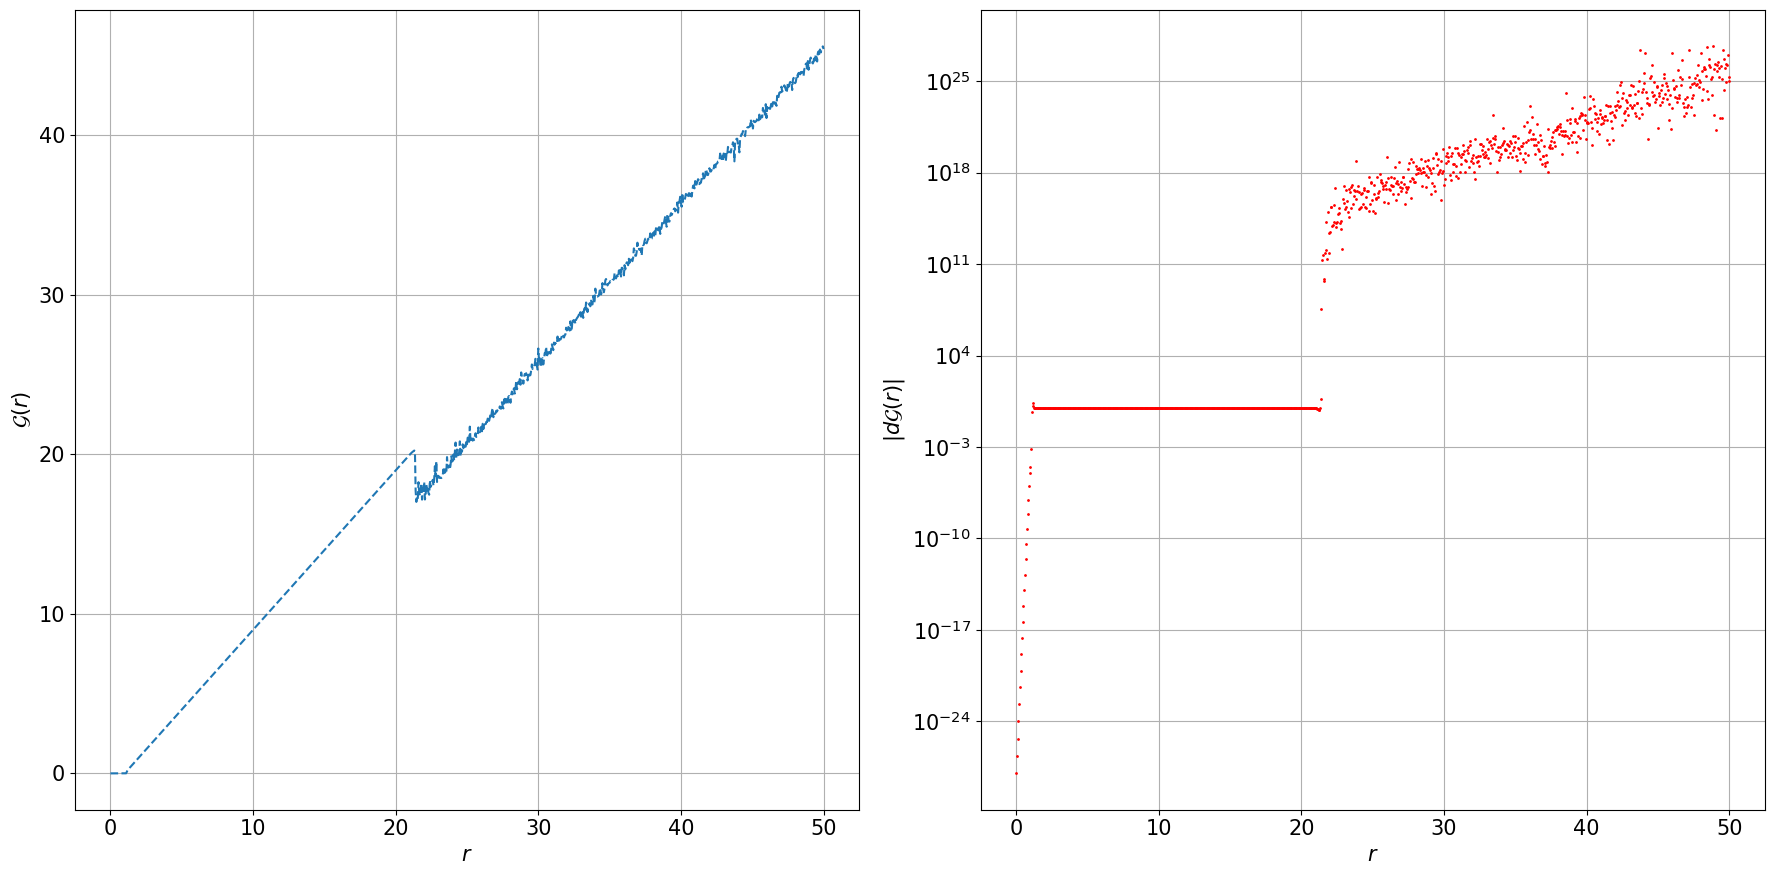

In [47]:
rs = Array(LinRange(0, 50, 1001))
rs, mean_x3s, dmean_x3_drs = compute_dx3_dr_adjoint(rs)
fig, (ax1, ax2) = PyPlot.subplots(ncols=2, figsize=(18,9))

ax1.plot(rs, mean_x3s, "--", fillstyle="none")
ax1.set_xlabel(L"r")
ax1.set_ylabel(L"\mathcal{G}(r)")
ax1.grid("on")



ax2.semilogy(rs, abs.(dmean_x3_drs), "or", markersize=1)
ax2.set_xlabel("\$r\$")
ax2.set_ylabel(L"|d\mathcal{G}(r)|")
ax2.grid("on")
fig.tight_layout()

## Intermittency and turbulence transition
* When $148.4 < r < 166.07$, the limit cycle begins
* When $166.07 < r$, the system transits to strange attractor from limit cyle.

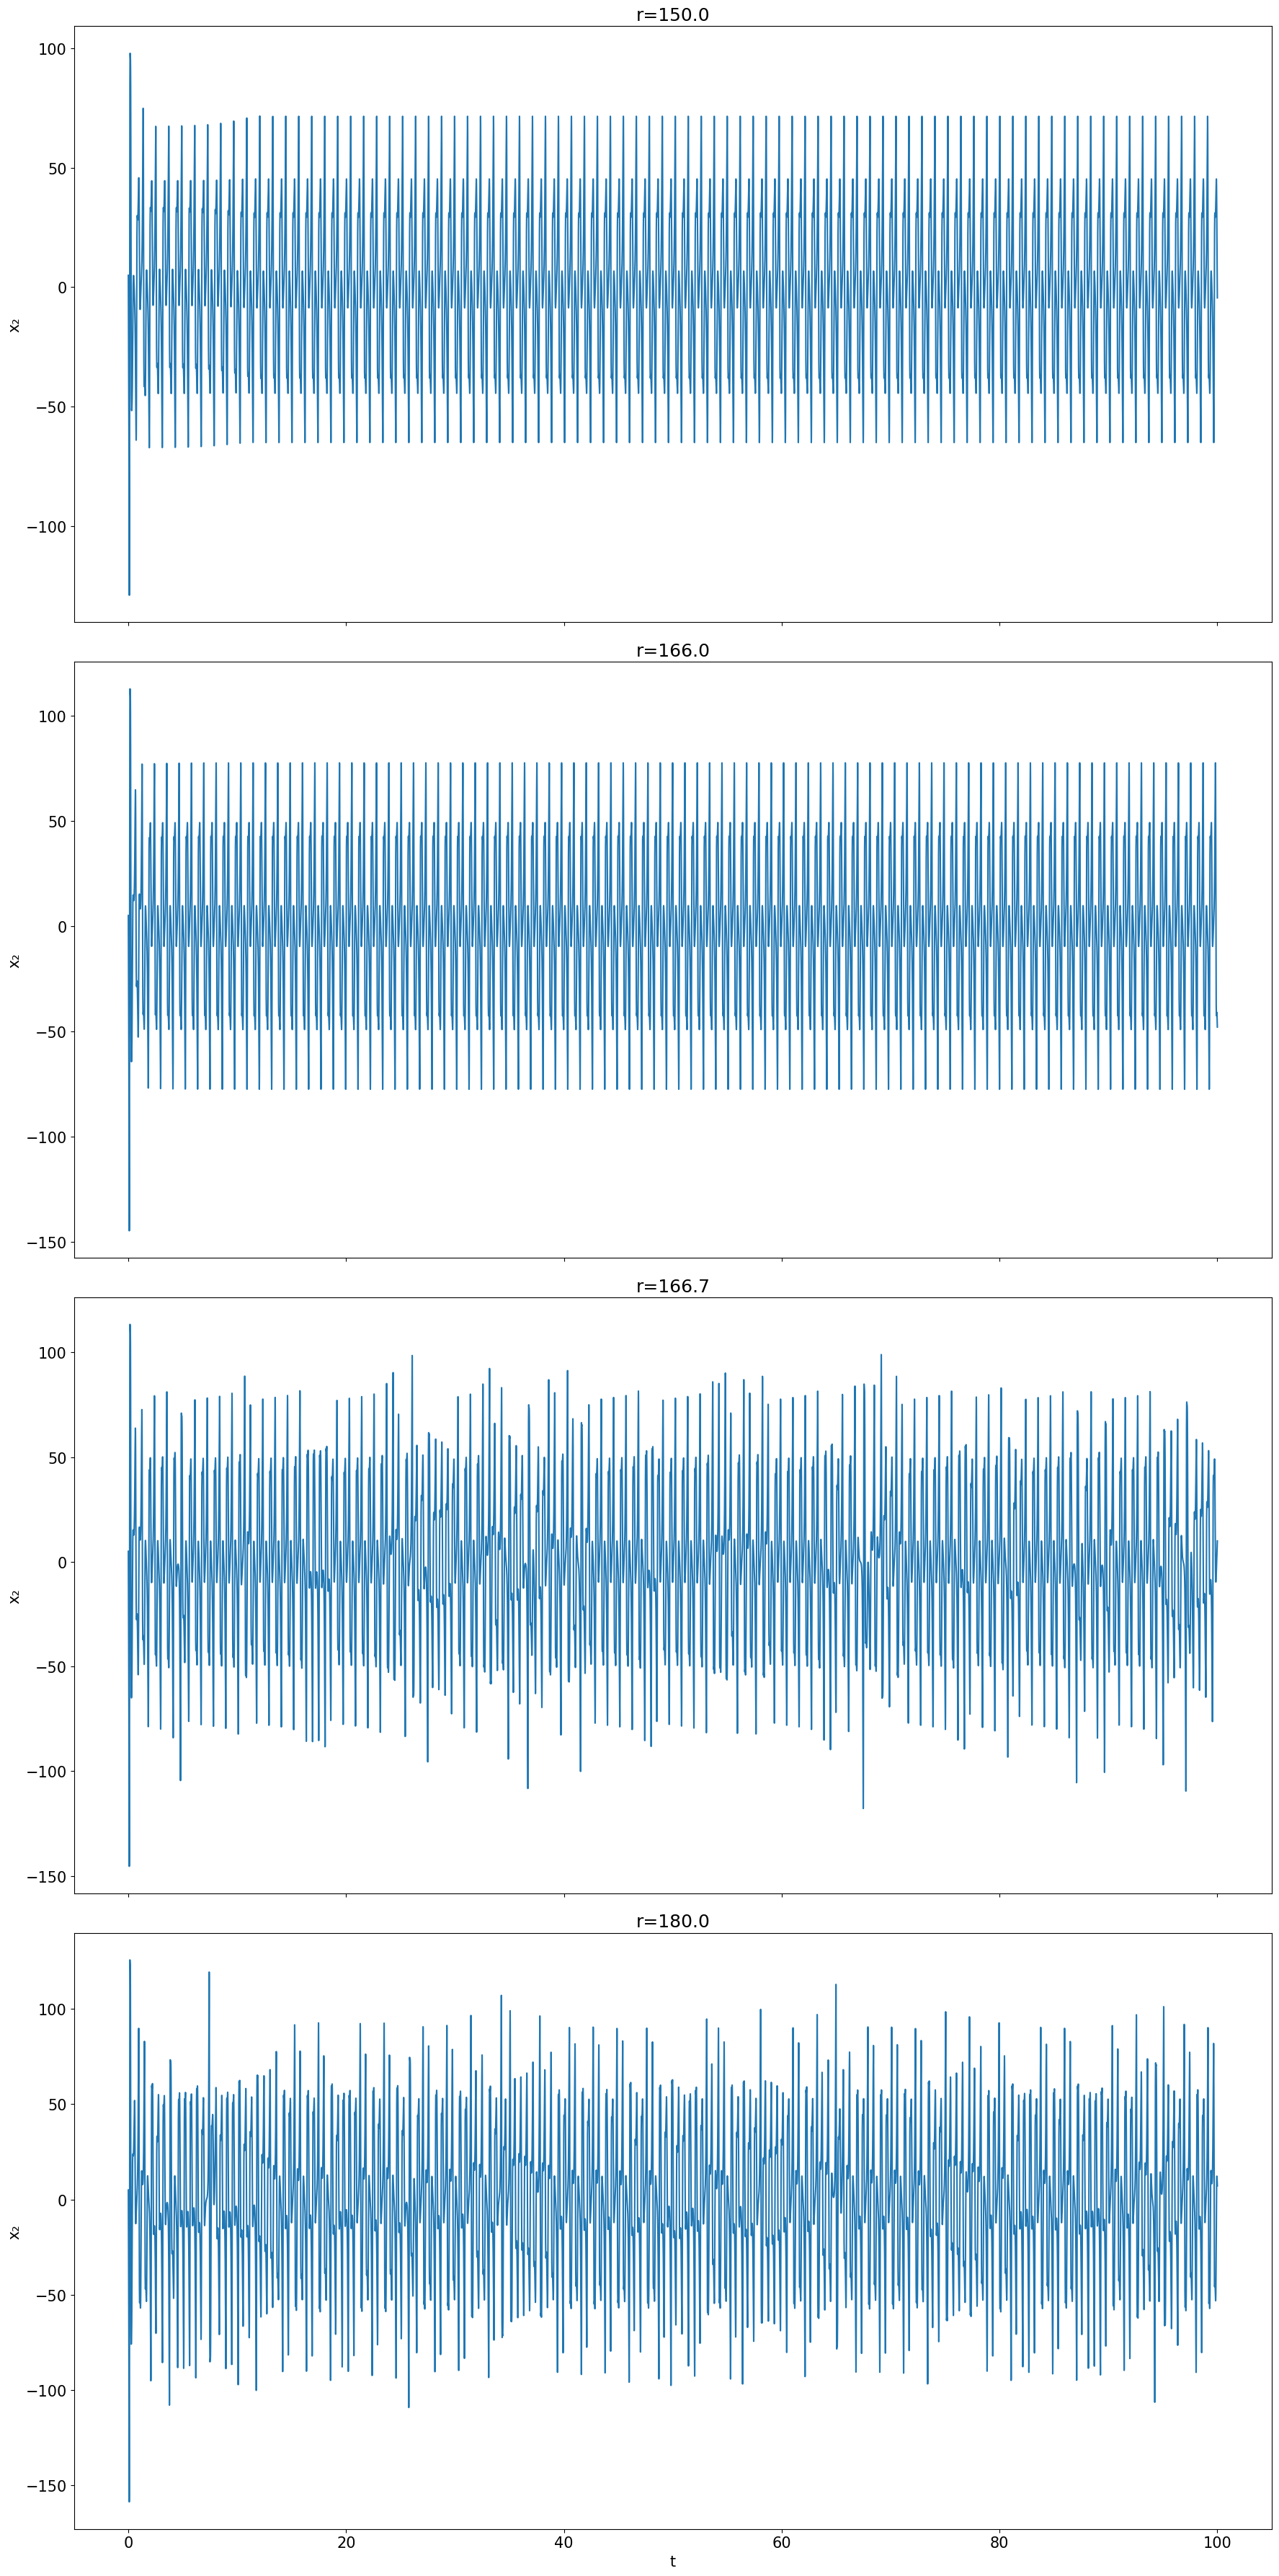

In [48]:
T = 100
Δt = 0.001
N_t = Int64(T/Δt)
ts = Array(LinRange(0, T, N_t+1))
x0 = [-8.67139571762; 4.98065219709; 25]

fig, ax = PyPlot.subplots(nrows=4, sharex=true, figsize=(18,36))

θ = [10.0; 150.0; 8.0/3.0]
xs = compute_Lorenz63_RK4(x0, θ, Δt, N_t)
ax[1].plot(ts, xs[2,:])
ax[1].set_ylabel("x₂")
ax[1].set_title("r=$(θ[2])")

θ = [10.0; 166.0; 8.0/3.0]
xs = compute_Lorenz63_RK4(x0, θ, Δt, N_t)
ax[2].plot(ts, xs[2,:])
ax[2].set_ylabel("x₂")
ax[2].set_title("r=$(θ[2])")

θ = [10.0; 166.7; 8.0/3.0]
xs = compute_Lorenz63_RK4(x0, θ, Δt, N_t)
ax[3].plot(ts, xs[2,:])
ax[3].set_ylabel("x₂")
ax[3].set_title("r=$(θ[2])")

θ = [10.0; 180.0; 8.0/3.0]
xs = compute_Lorenz63_RK4(x0, θ, Δt, N_t)
ax[4].plot(ts, xs[2,:])
ax[4].set_ylabel("x₂")
ax[4].set_title("r=$(θ[2])")

ax[4].set_xlabel("t")
PyPlot.tight_layout()